
# **FIAP – Fase 6 (Parte 2) – Comparação YOLO vs CNN**
**FarmTech Solutions – O Começo da Rede Neural**  
Autor: *Carlos Mario* | RM: *RM563769*  
Data de geração deste notebook: 2025-10-14 03:58:35  

> **Objetivo:** Comparar três abordagens de visão computacional usando a mesma base da Entrega 1:  
> 1) **YOLOv5 Adaptável** (*pesos treinados na Entrega 1*)  
> 2) **YOLOv5 Padrão** (*treino baseline com hiperparâmetros default*)  
> 3) **CNN do zero (classificação)** (*a partir das imagens e rótulos da YOLO*)



## ✅ **Checklist de Pré-Requisitos**
- Sua base no **Google Drive** organizada conforme a Entrega 1 (imagens e rótulos YOLO-format).
- Um arquivo `dataset.yaml` no padrão YOLO com caminhos relativos para `train`, `val`, `test`, e a lista de `names` das classes.
- Os **pesos** treinados na Entrega 1 (por exemplo, `runs/train/expX/weights/best.pt`) salvos no Drive.
- Colab com GPU ativada (*Runtime > Change runtime type > GPU*).

> Se seu dataset tiver **apenas um objeto por imagem**, a conversão para classificação é direta. Caso haja múltiplos objetos por imagem, este notebook **seleciona a classe dominante** (maior número de anotações) para fins de classificação. Imagens com **empate** podem ser **ignoradas** para a CNN.


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 14 22:51:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   38C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----


## 1) Ambiente: Montagem do Drive e Instalação de Dependências


In [2]:

#@title Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive montado.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive montado.


In [3]:

#@title Instalar YOLOv5 e dependências PyTorch/Ultralytics
!pip -q install --upgrade pip
!pip -q install ultralytics==8.2.103  # para utilidades e inferências
!git clone -q https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip -q install -r requirements.txt
%cd /content
print("✅ YOLOv5 instalado.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
/content/yolov5
/content
✅ YOLOv5 instalado.


In [4]:

#@title Instalar dependências para a CNN (TensorFlow/Keras) e métricas
!pip install -q tensorflow==2.16.1
!pip install -q numpy==1.26.4  # This was installed before, let's keep it for now.
!pip install -q ml_dtypes>=0.5.0  # As required by tensorstore
!pip install -q tensorstore
!pip install -q tensorflow-text
!pip install -q grpcio-status
!pip install -q jax
!pip install -q umap-learn
!pip install -q tf-keras
!pip install -q tensorflow-decision-forests
!pip install -q ydf
!pip -q install scikit-learn==1.5.2 matplotlib==3.8.4 pandas==2.2.2
print("✅ TensorFlow/Keras e libs instaladas.")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.78 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.16.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
jax 0.5.3 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.16.1 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompat


## 2) Variáveis de Caminho (Ajuste para seu Drive)
Preencha os caminhos abaixo antes de rodar o notebook.


In [5]:

#@title 🔧 Configuração de caminhos (EDITE AQUI)
from pathlib import Path

# Caminho do YAML do dataset YOLO (no Drive)
DATASET_YAML_PATH = "/content/drive/MyDrive/FarmTech-Parte2/dataset/dataset.yaml"  #@param {type:"string"}

# Caminho dos pesos treinados na Entrega 1 (YOLO adaptável)
CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/FarmTech-Parte2/results/farmtech_60_epochs/weights/best.pt"  #@param {type:"string"}

# Pasta para salvar saídas desta Parte 2
OUTPUT_DIR = "/content/drive/MyDrive/FarmTech-Parte2/entrega2_outputs"  #@param {type:"string"}

# Pasta temporária (local) para classificação (gerada a partir de rótulos YOLO)
CLASS_DATASET_DIR = "/content/classification_ds"

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print("✅ Config aplicado.")
print("DATASET_YAML_PATH:", DATASET_YAML_PATH)
print("CUSTOM_WEIGHTS_PATH:", CUSTOM_WEIGHTS_PATH)
print("OUTPUT_DIR:", OUTPUT_DIR)


✅ Config aplicado.
DATASET_YAML_PATH: /content/drive/MyDrive/FarmTech-Parte2/dataset/dataset.yaml
CUSTOM_WEIGHTS_PATH: /content/drive/MyDrive/FarmTech-Parte2/results/farmtech_60_epochs/weights/best.pt
OUTPUT_DIR: /content/drive/MyDrive/FarmTech-Parte2/entrega2_outputs



## 3) YOLOv5 Padrão (Baseline) – Treino e Validação
Treinaremos a YOLOv5s com **hiperparâmetros padrão** (sem ajustes finos), para comparar com o modelo customizado da Entrega 1.


In [7]:

#@title Treinar YOLOv5 (baseline - hiperparâmetros padrão)
import os, json, shutil, time, sys

%cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 30 --data "$DATASET_YAML_PATH" --weights yolov5s.pt --name fase6_yolo_baseline --project /content/yolo_runs

# Registrar o caminho do experimento
BASELINE_EXP_DIR = "/content/yolo_runs/fase6_yolo_baseline"
print("✅ Treino baseline finalizado em:", BASELINE_EXP_DIR)
%cd /content


/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-10-14 23:07:55.963034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760483275.985130   20713 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760483275.991731   20713 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760483276.008247   20713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760483276.008284   20713 computation_placer.cc:177] computation placer a

Contents of /content/yolo_runs/fase6_yolo_baseline:
confusion_matrix.png
val_batch0_labels.jpg
weights
train_batch2.jpg
labels.jpg
val_batch0_pred.jpg
train_batch1.jpg
labels_correlogram.jpg
opt.yaml
results.csv
hyp.yaml
F1_curve.png
P_curve.png
train_batch0.jpg
results.png
PR_curve.png
R_curve.png
events.out.tfevents.1760480838.253eed830b35.9583.0

results.txt not found.

Displaying relevant plots (if found):

Displaying results.png:


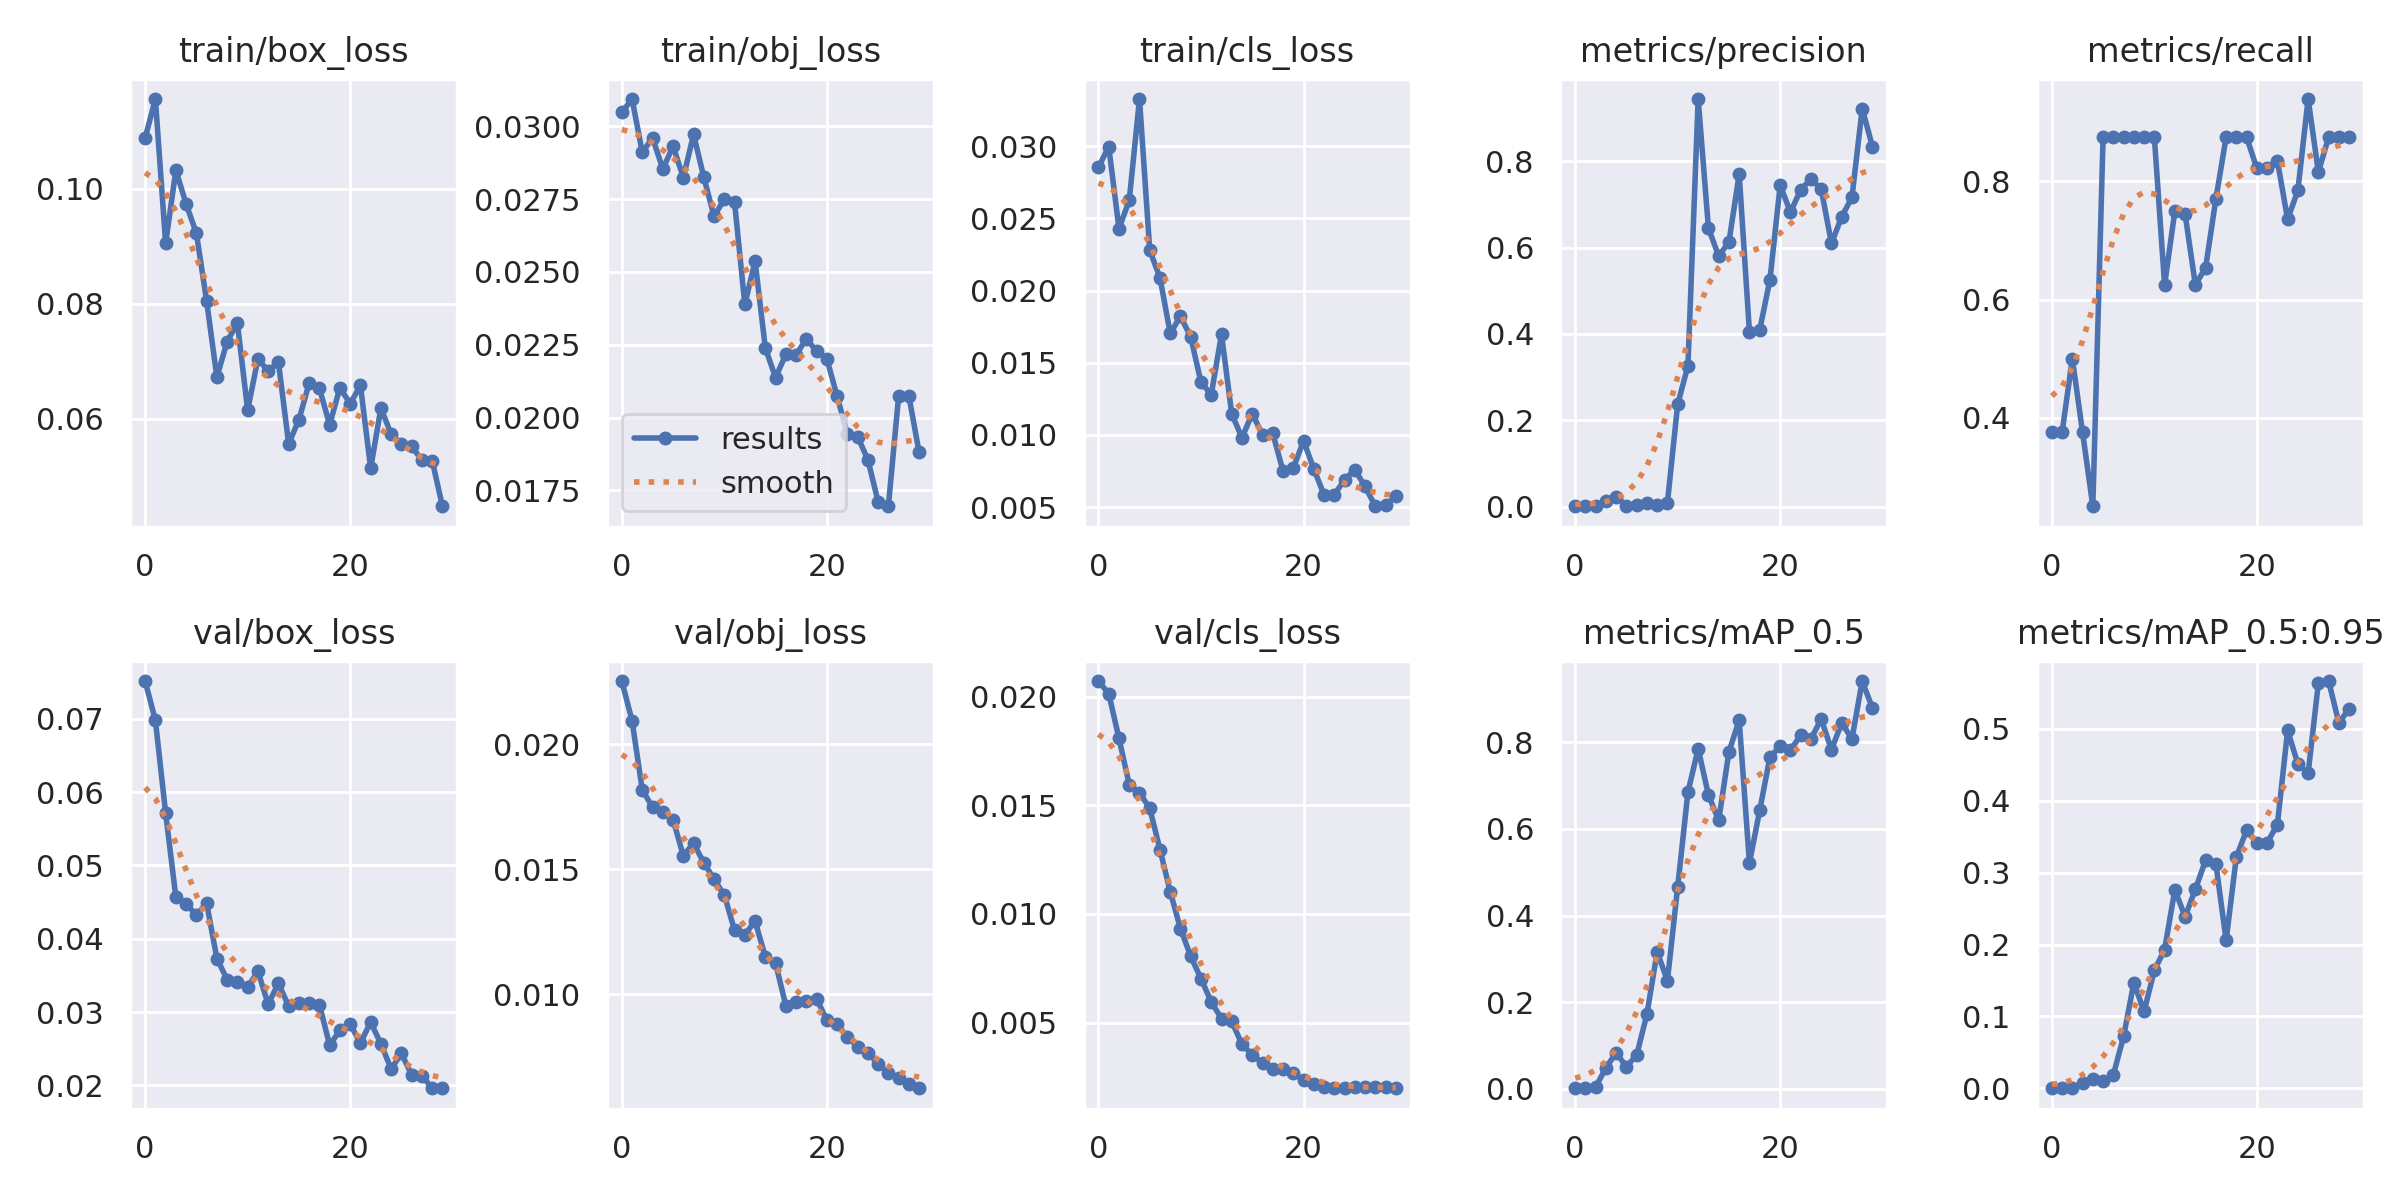


Displaying confusion_matrix.png:


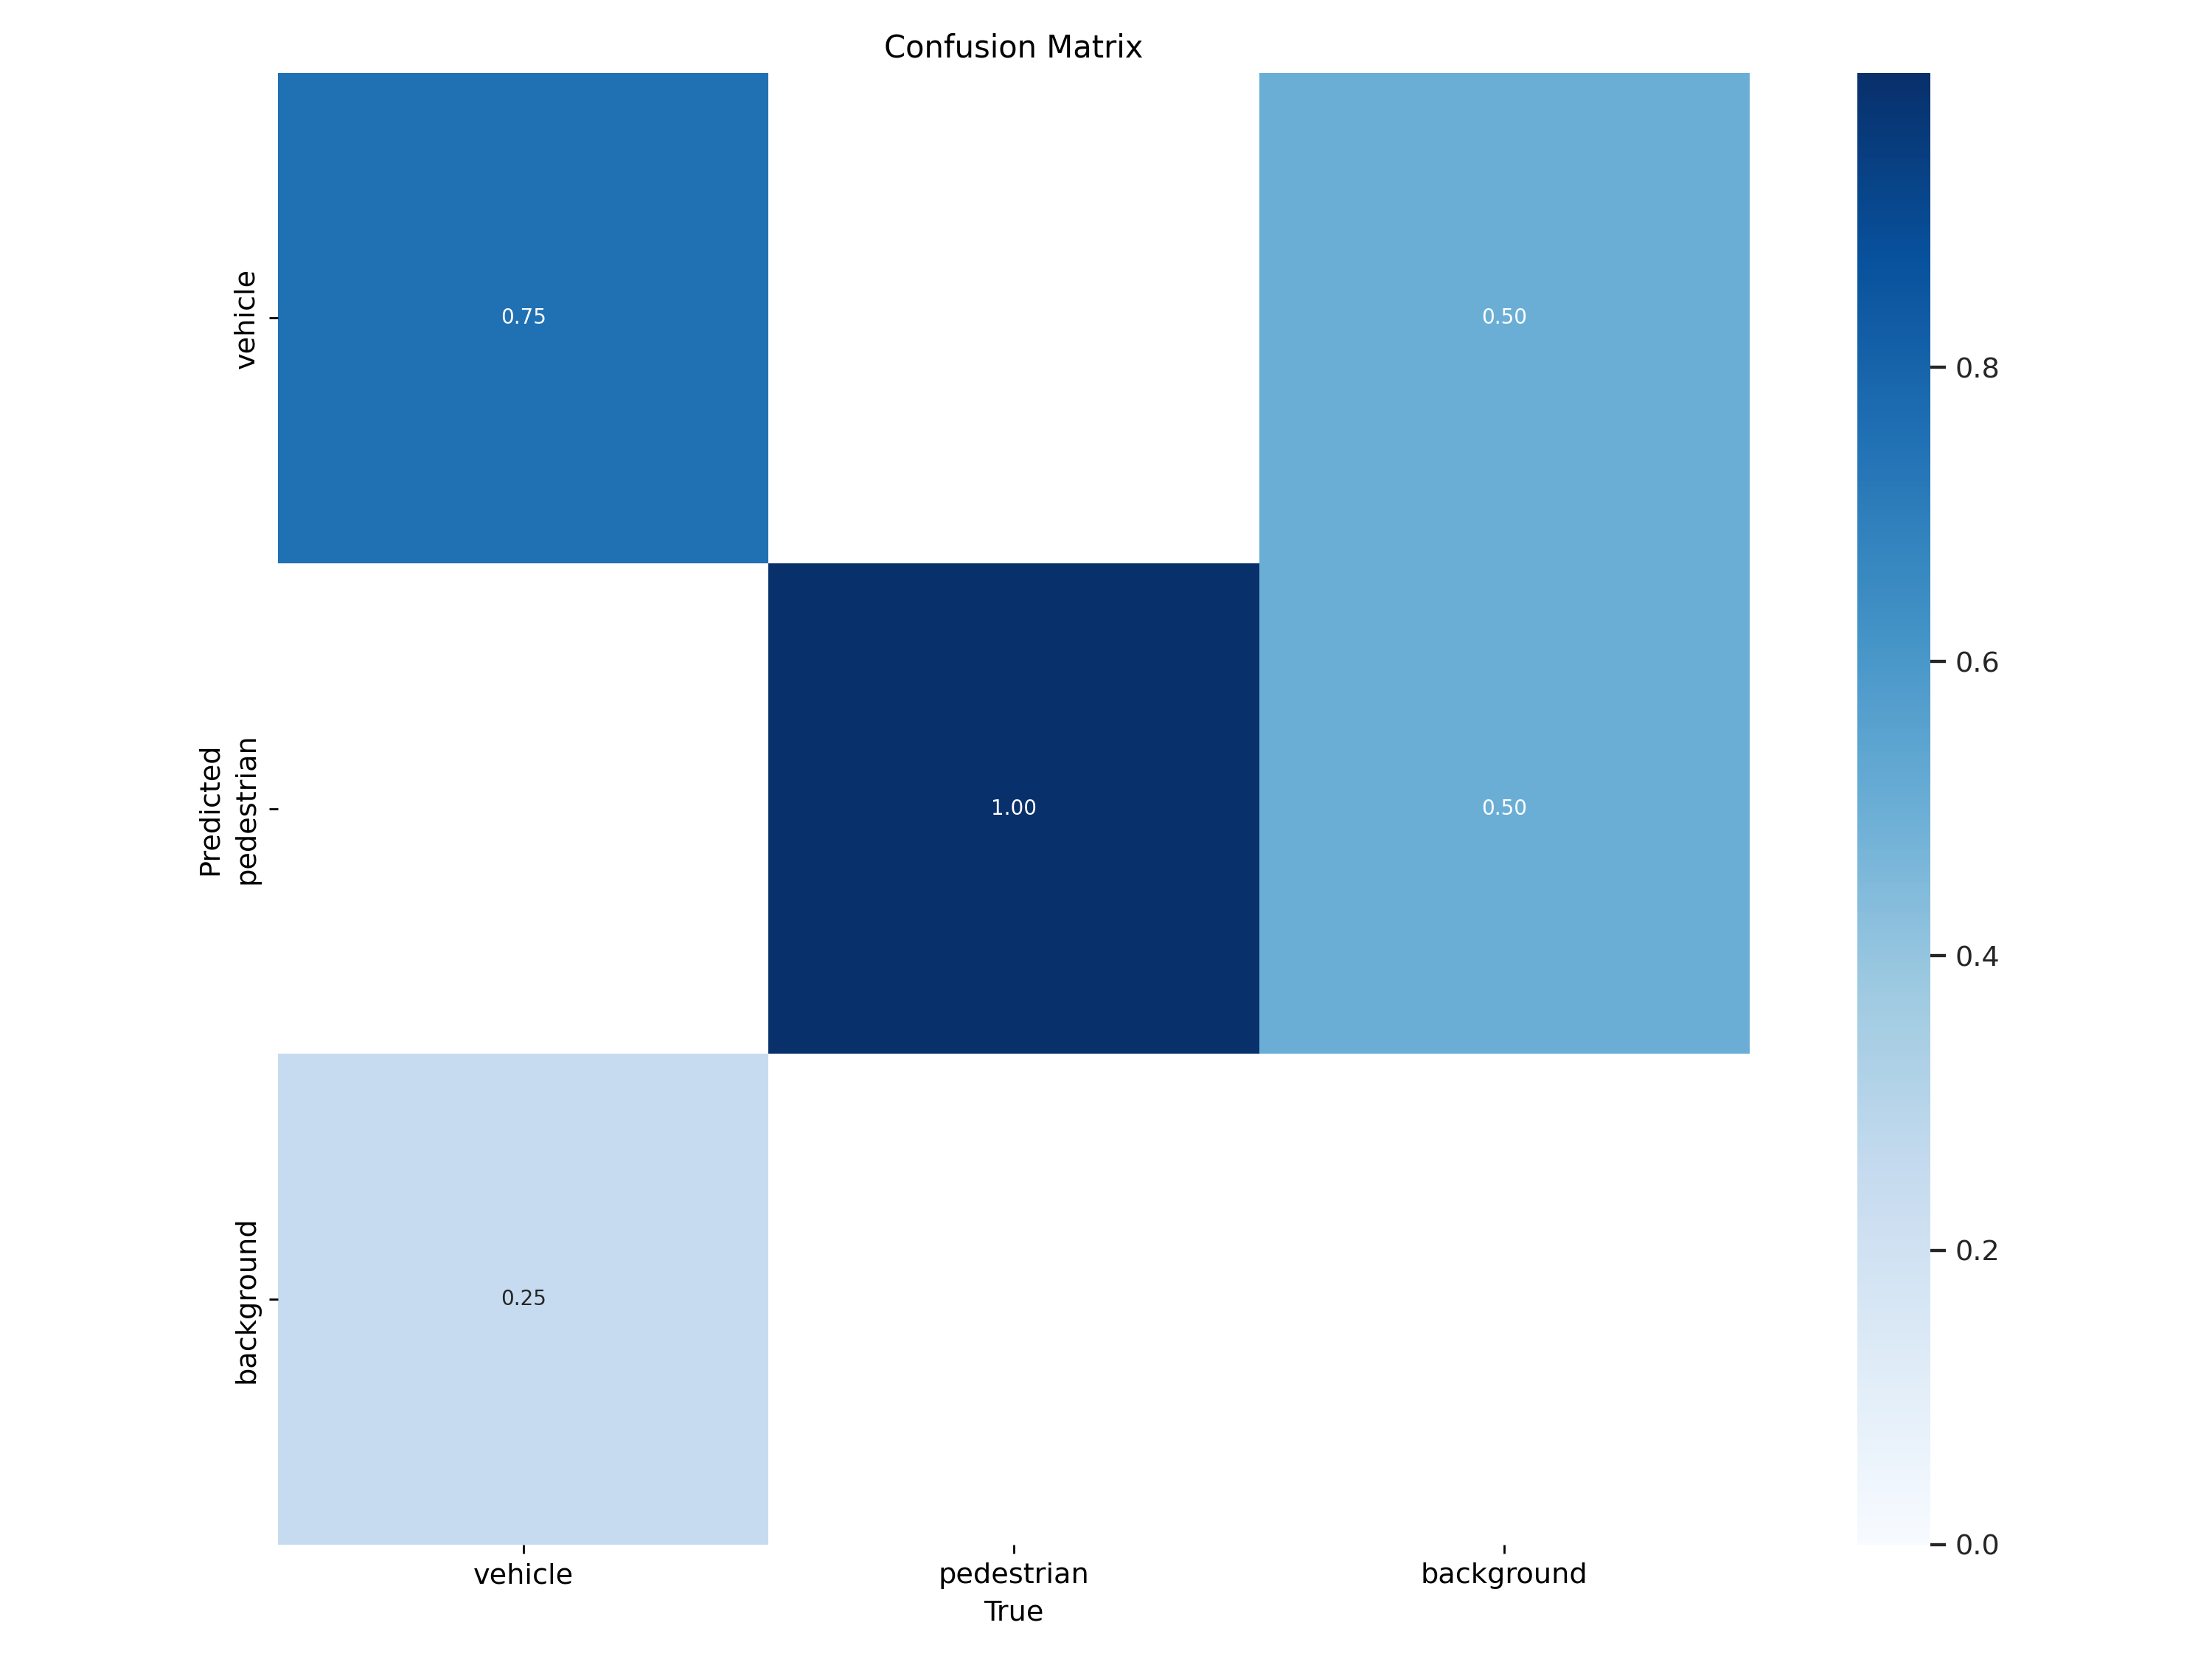


Displaying F1_curve.png:


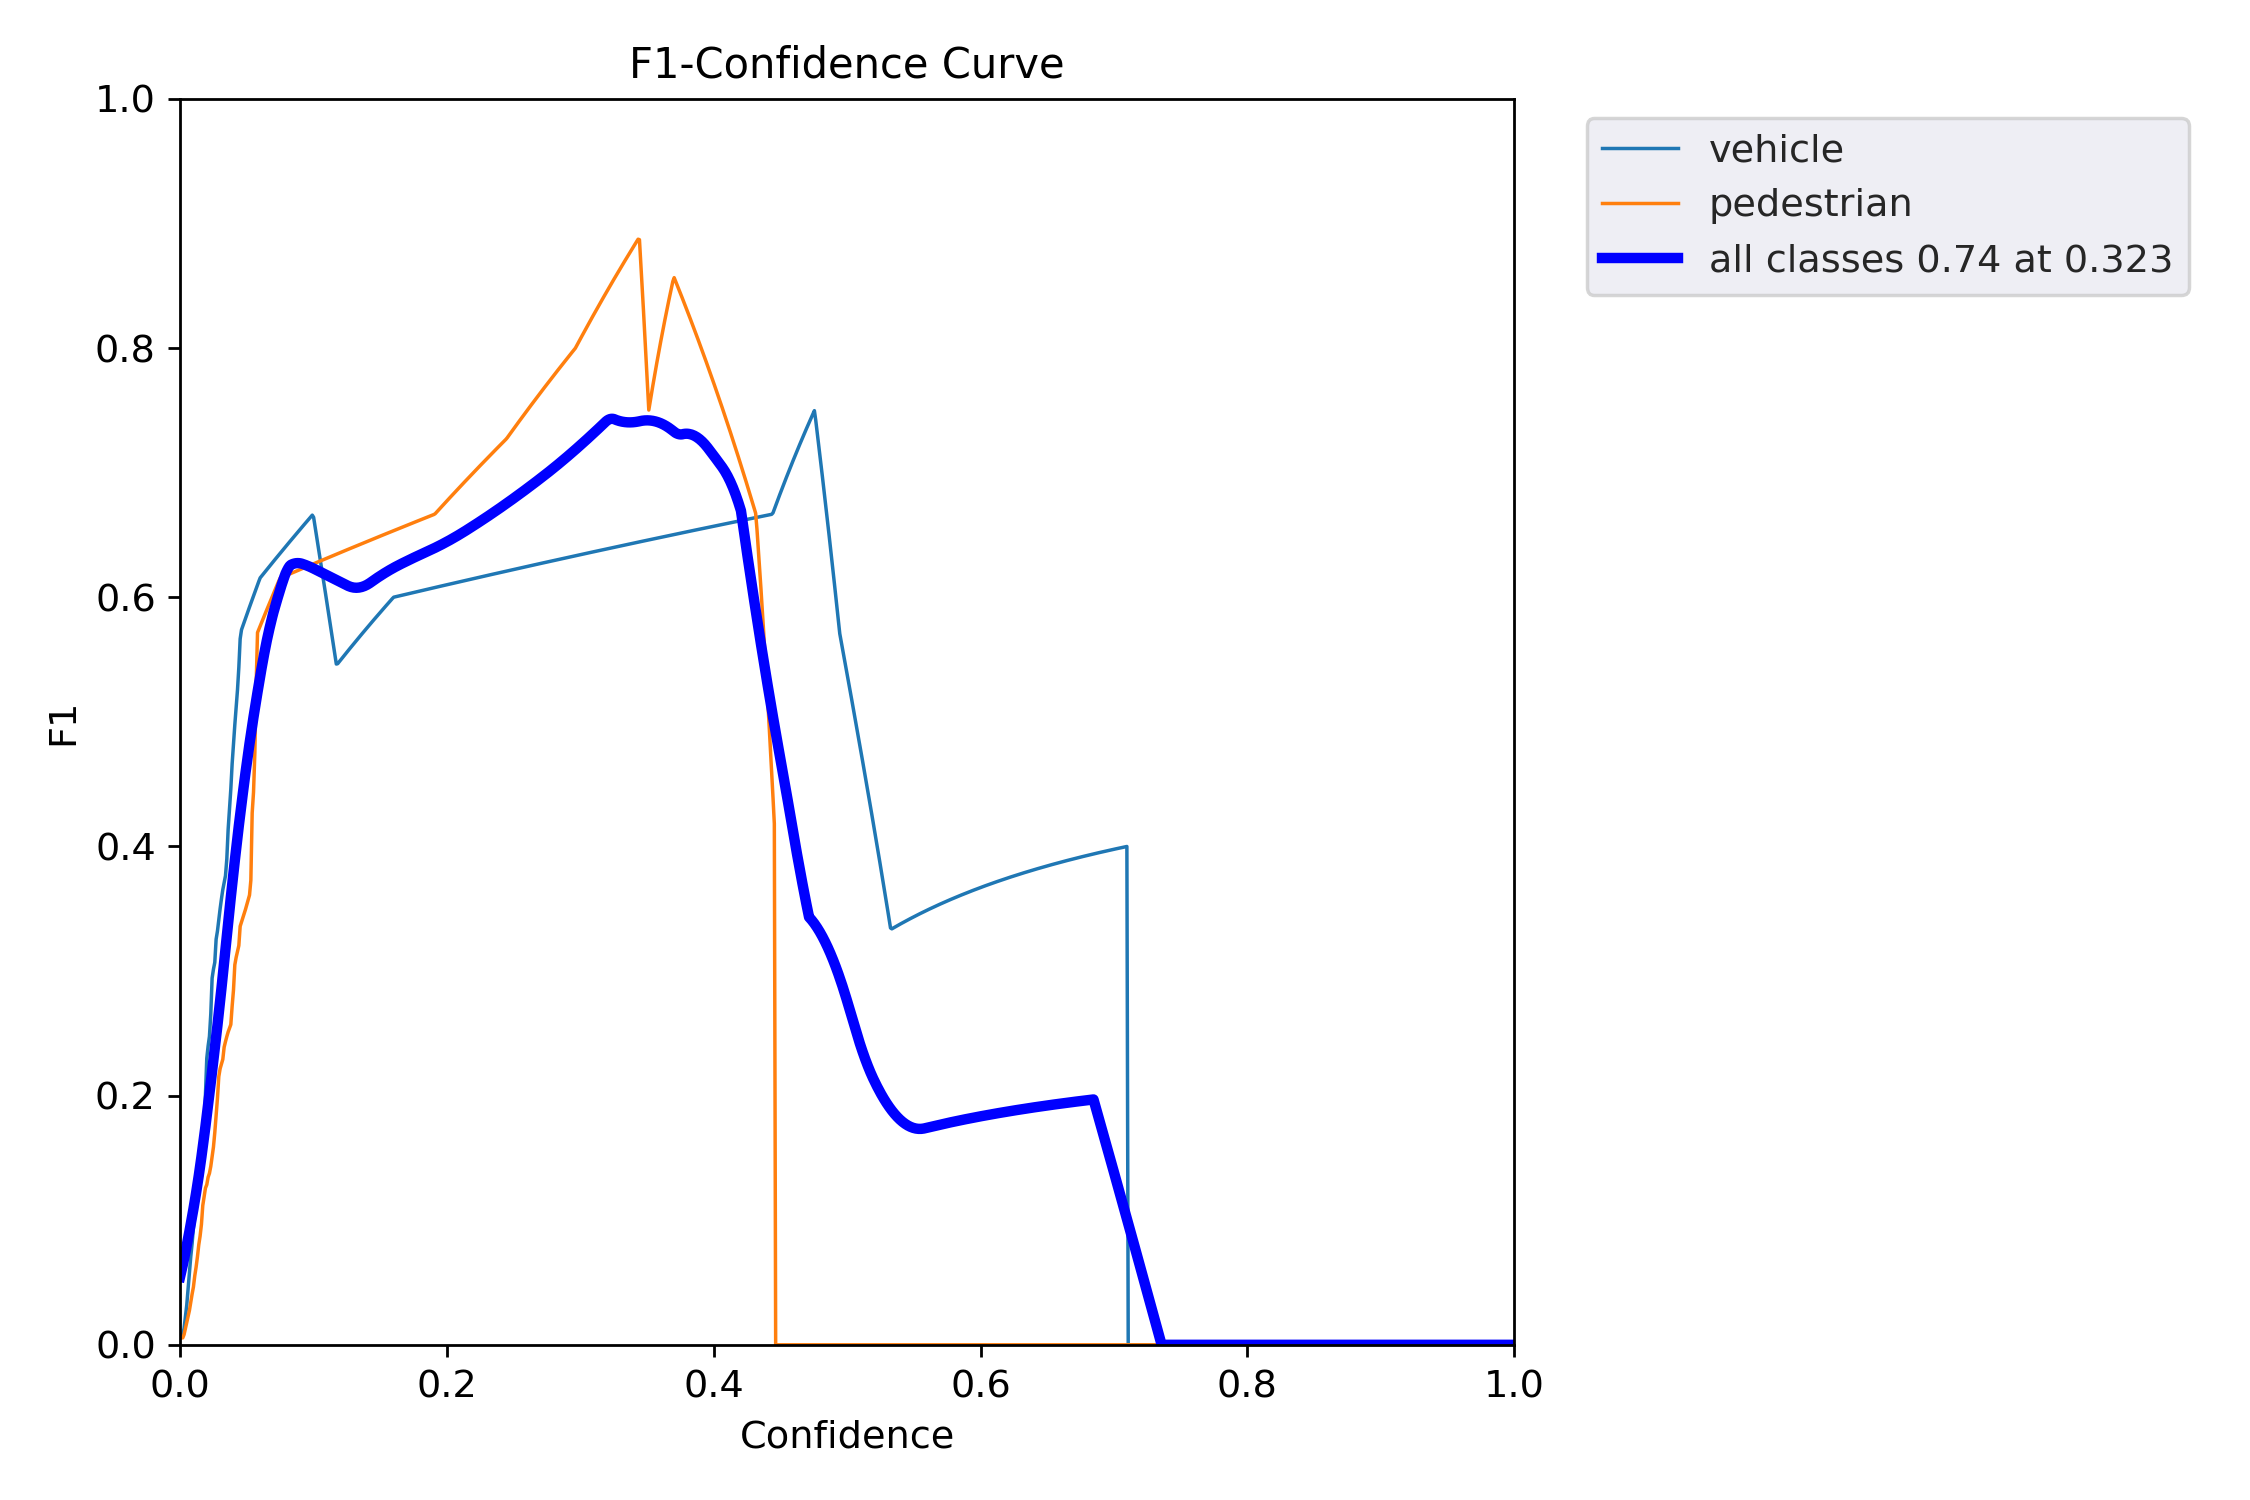


Displaying P_curve.png:


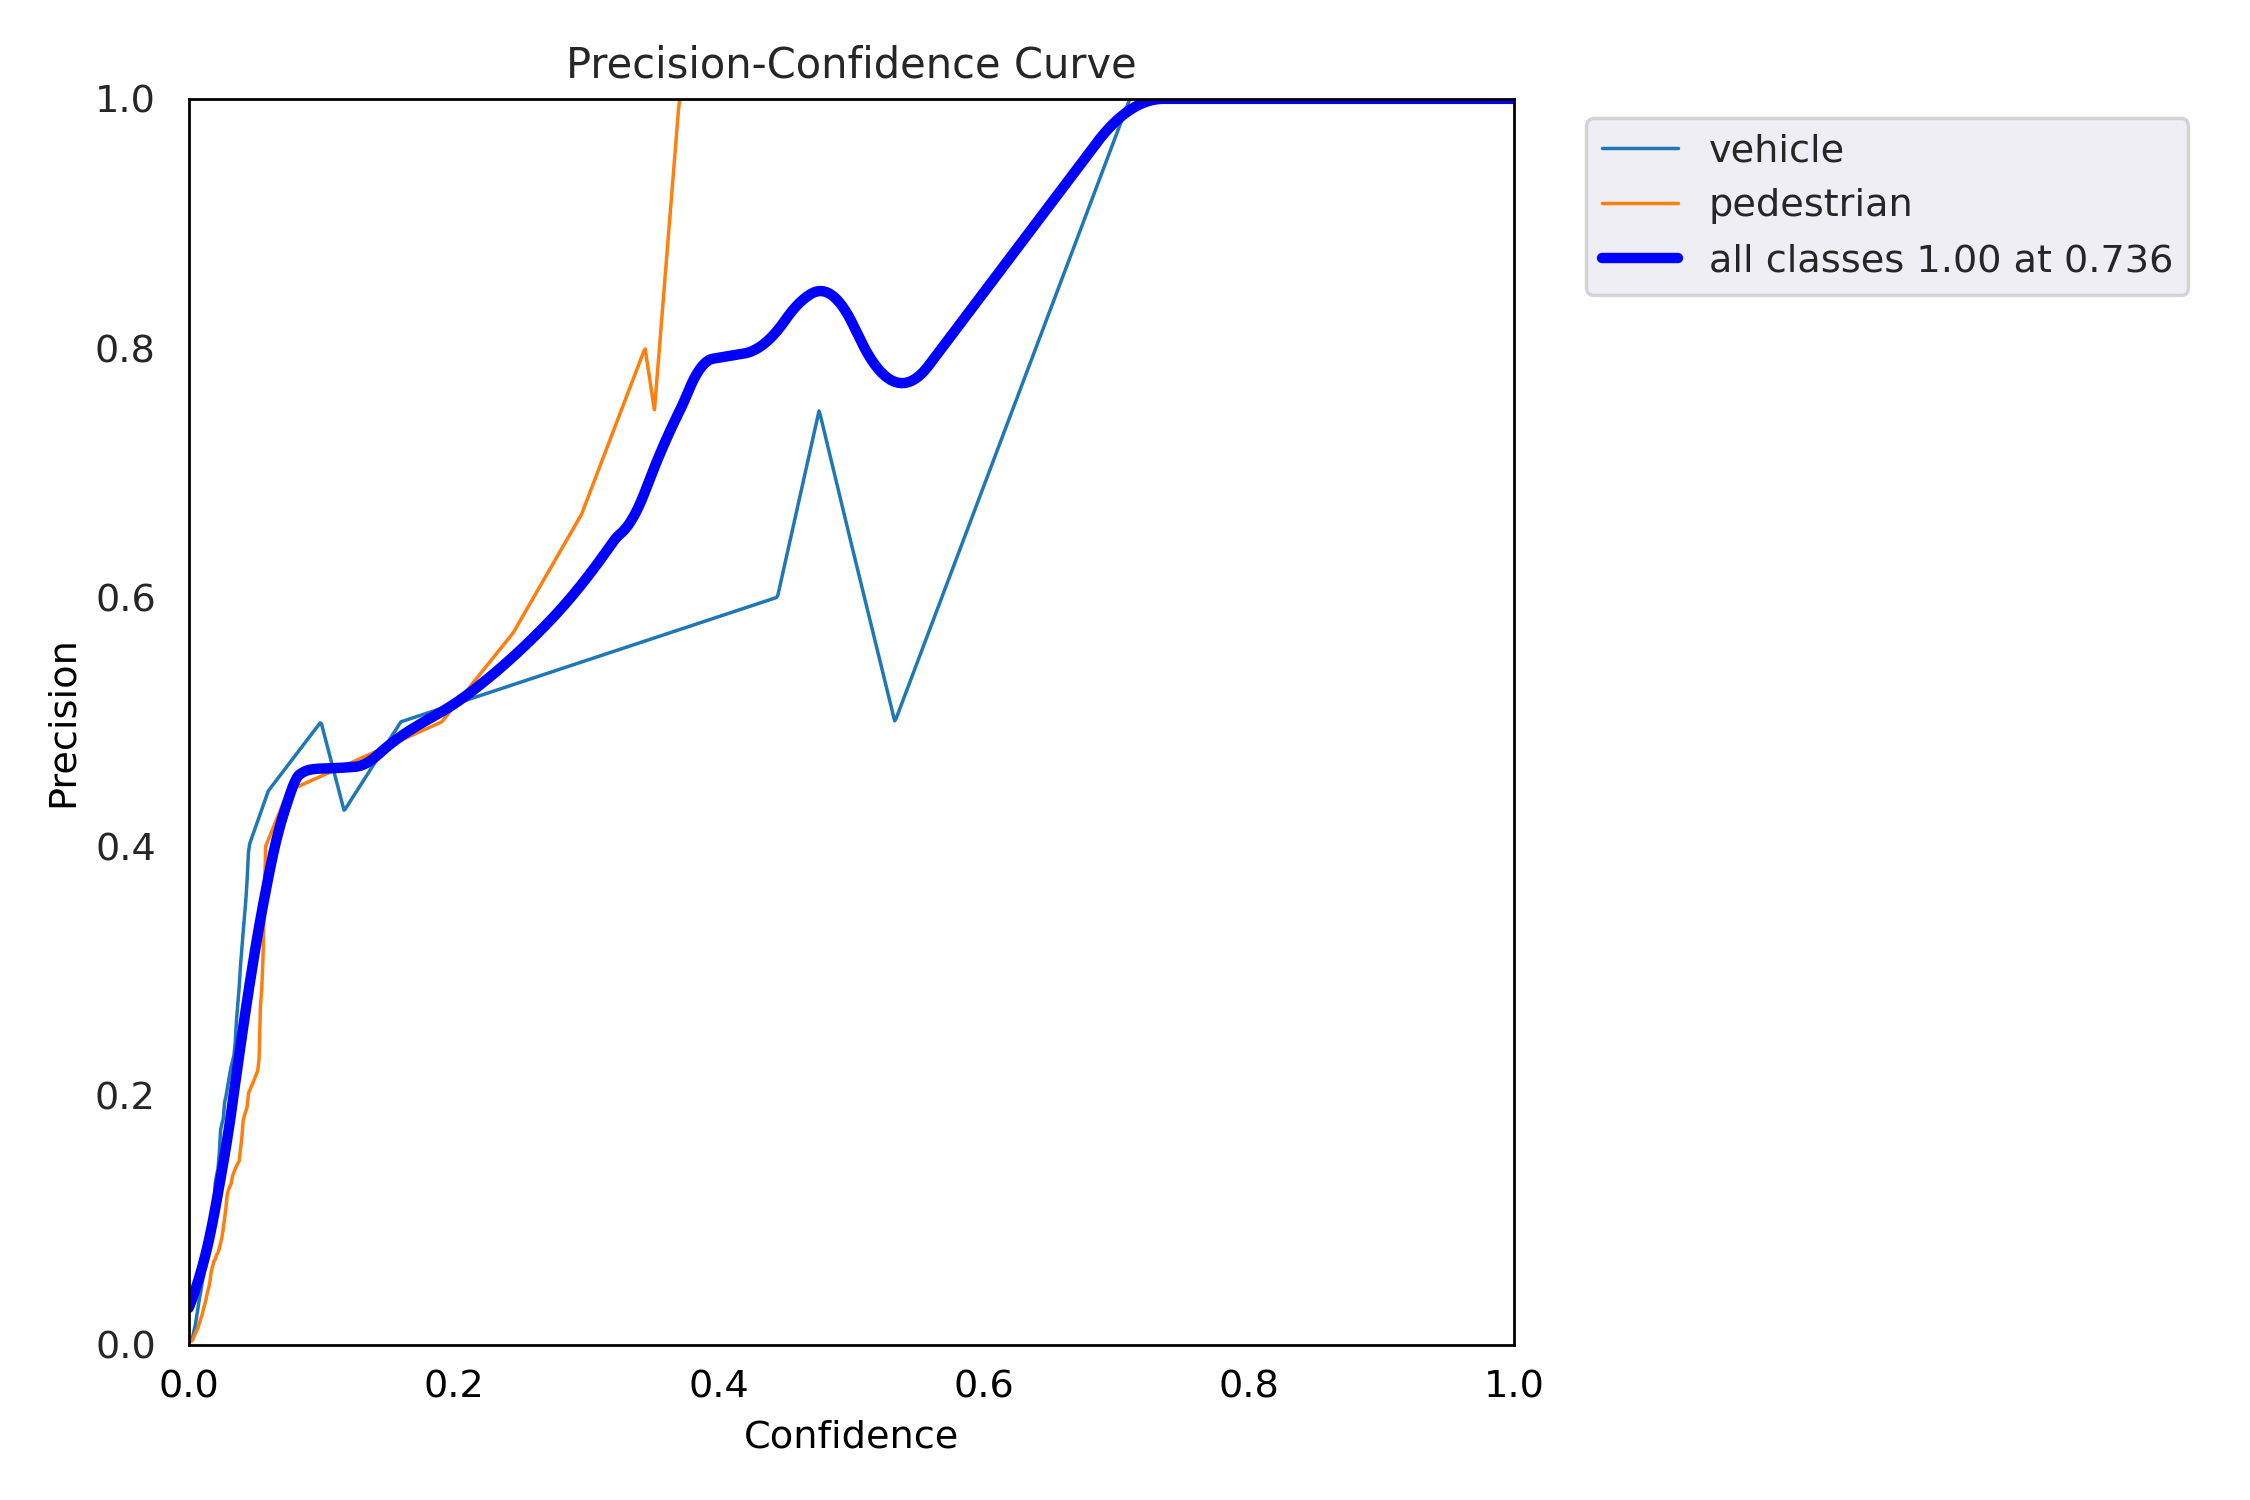


Displaying R_curve.png:


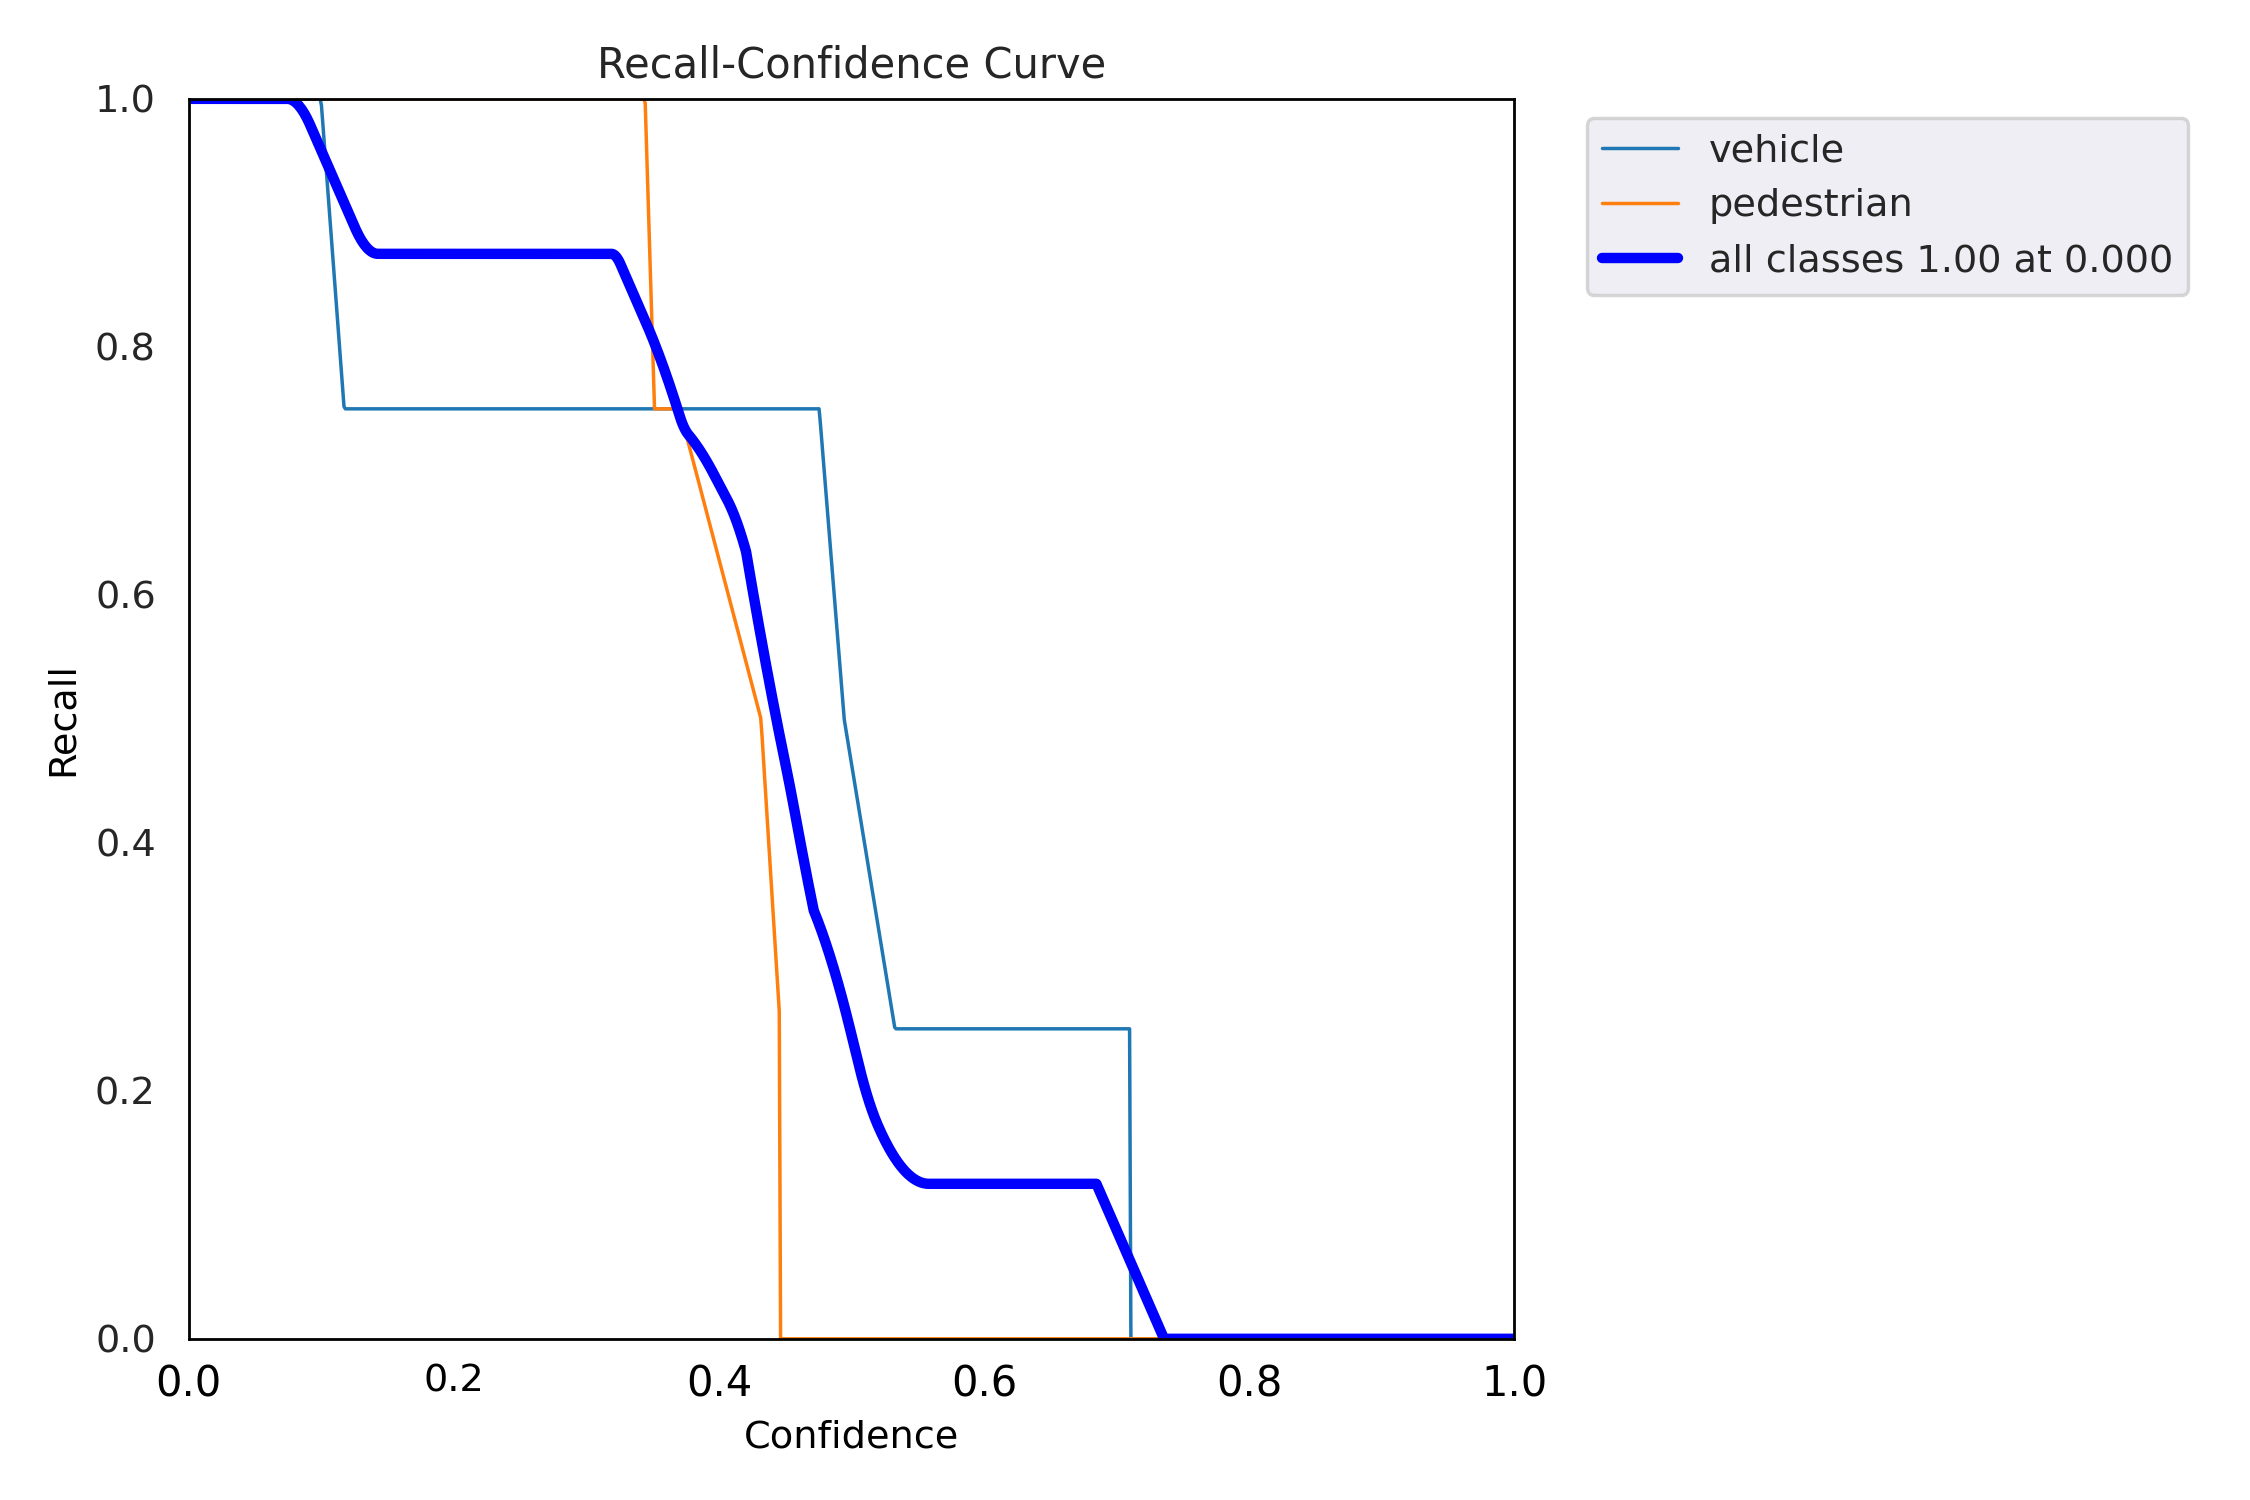

In [8]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

results_dir = "/content/yolo_runs/fase6_yolo_baseline"

print(f"Contents of {results_dir}:")
for item in os.listdir(results_dir):
    print(item)

# Try to display results.txt
results_txt_path = os.path.join(results_dir, 'results.txt')
if os.path.exists(results_txt_path):
    print("\nContents of results.txt:")
    with open(results_txt_path, 'r') as f:
        print(f.read())
else:
    print("\nresults.txt not found.")

# Try to display relevant plots (e.g., results.png, confusion_matrix.png)
plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'P_curve.png', 'R_curve.png']
print("\nDisplaying relevant plots (if found):")
for plot_file in plot_files:
    plot_path = os.path.join(results_dir, plot_file)
    if os.path.exists(plot_path):
        print(f"\nDisplaying {plot_file}:")
        display(Image(plot_path))
    else:
        print(f"{plot_file} not found.")

In [9]:

#@title Avaliar YOLOv5 Baseline no conjunto de teste
%cd /content/yolov5
!python val.py --weights "/content/yolo_runs/fase6_yolo_baseline/weights/best.pt" --data "$DATASET_YAML_PATH" --task test --img 640 --name fase6_yolo_baseline_test --project /content/yolo_val
print("✅ Avaliação baseline concluída.")
%cd /content


/content/yolov5
val: data=/content/drive/MyDrive/FarmTech-Parte2/dataset/dataset.yaml, weights=['/content/yolo_runs/fase6_yolo_baseline/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/yolo_val, name=fase6_yolo_baseline_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/drive/MyDrive/FarmTech_YOLO_Project/dataset/test/labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100% 8/8 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.18it/s]
                   all          8          8      0.594      


## 4) YOLOv5 Adaptável (Pesos da Entrega 1) – Avaliação
Carregamos os **pesos customizados** (melhor epoch da Entrega 1) e avaliamos no conjunto de teste para comparação direta.


In [11]:

#@title Avaliar YOLOv5 (pesos customizados da Entrega 1) no teste
from pathlib import Path

assert Path(CUSTOM_WEIGHTS_PATH).exists(), "❌ CUSTOM_WEIGHTS_PATH não encontrado."
%cd /content/yolov5
!python val.py --weights "$CUSTOM_WEIGHTS_PATH" --data "$DATASET_YAML_PATH" --task test --img 640 --name fase6_yolo_custom_test --project /content/yolo_val
print("✅ Avaliação YOLO customizada concluída.")
%cd /content


/content/yolov5
val: data=/content/drive/MyDrive/FarmTech-Parte2/dataset/dataset.yaml, weights=['/content/drive/MyDrive/FarmTech-Parte2/results/farmtech_60_epochs/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/yolo_val, name=fase6_yolo_custom_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/drive/MyDrive/FarmTech_YOLO_Project/dataset/test/labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100% 8/8 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.15it/s]
                   all          8   


## 5) Conversão do Dataset YOLO → Classificação (2 classes)
A CNN requer pastas por classe (`train/classA`, `train/classB`, ...).  
Este passo usa os **arquivos de rótulo YOLO** para determinar a **classe dominante** da imagem e cria uma cópia em uma estrutura de diretórios de classificação.

> Regras:  
> - Se a imagem tiver **uma única classe**, usa-se aquela.  
> - Se tiver **várias classes**, escolhe-se a **mais frequente** na imagem.  
> - Se houver **empate**, a imagem é **ignoradas** para a CNN.


In [10]:
#@title Conversão rótulos YOLO → dataset de classificação
import os, shutil, yaml, glob
from pathlib import Path
from collections import Counter

CLASS_DATASET_DIR = Path("/content/classification_ds")
if CLASS_DATASET_DIR.exists():
    shutil.rmtree(CLASS_DATASET_DIR)
CLASS_DATASET_DIR.mkdir(parents=True, exist_ok=True)

with open(DATASET_YAML_PATH, 'r') as f:
    ds = yaml.safe_load(f)

# ds['train'], ds['val'], ds['test'] podem ser pastas ou arquivos .txt com listas.
def resolve_image_paths(entry):
    # Ensure the entry path is treated as relative to the directory containing the YAML file
    yaml_dir = Path(DATASET_YAML_PATH).parent
    p = yaml_dir / entry
    if p.suffix.lower() == ".txt":
        with open(p) as fp:
            # Assuming the paths in the txt file are also relative to the yaml_dir
            return [yaml_dir / line.strip() for line in fp if line.strip()]
    else:
        # assume diretório com imagens
        exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp")
        paths = []
        for ext in exts:
            paths.extend(Path(p).rglob(ext))
        return paths

splits = {'train': ds['train'], 'val': ds.get('val', None), 'test': ds.get('test', None)}
names = ds.get('names', None)
if isinstance(names, dict):
    # YOLO às vezes usa dict {0:'A',1:'B'}
    class_names = [names[k] for k in sorted(names.keys(), key=int)]
else:
    class_names = list(names)

def yolo_label_path(img_path):
    # YOLO: images/ -> labels/, ext -> .txt
    img_path = Path(img_path)
    if "images" in img_path.parts:
        idx = img_path.parts.index("images")
        lbl_parts = list(img_path.parts)
        lbl_parts[idx] = "labels"
        lbl_path = Path(*lbl_parts).with_suffix(".txt")
        return lbl_path
    else:
        # fallback: assume pasta paralela labels with same basename
        return img_path.with_suffix(".txt").parent.parent / "labels" / (img_path.stem + ".txt")

def dominant_class(label_file):
    if not label_file.exists():
        return None
    cls_ids = []
    with open(label_file) as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls_ids.append(int(parts[0]))
    if not cls_ids:
        return None
    count = Counter(cls_ids)
    most_common = count.most_common()
    if len(most_common) == 1 or (len(most_common) > 1 and most_common[0][1] > most_common[1][1]):
        return most_common[0][0]
    return None  # empate

def copy_for_split(split_name, sources):
    if not sources:
        return 0, 0
    kept, skipped = 0, 0
    for img in sources:
        lbl = yolo_label_path(img)
        cls_id = dominant_class(lbl)
        if cls_id is None:
            skipped += 1
            continue
        cls_name = class_names[cls_id] if class_names and cls_id < len(class_names) else f"class_{cls_id}"
        out_dir = CLASS_DATASET_DIR / split_name / cls_name
        out_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy2(img, out_dir / img.name)
        kept += 1
    return kept, skipped

stats = {}
for split_name, entry in splits.items():
    if entry is None:
        continue
    imgs = resolve_image_paths(entry)
    kept, skipped = copy_for_split(split_name, imgs)
    stats[split_name] = dict(kept=kept, skipped=skipped)

print("✅ Conversão concluída.")
print(stats)
print("Estrutura criada em:", CLASS_DATASET_DIR)

✅ Conversão concluída.
{'train': {'kept': 62, 'skipped': 2}, 'val': {'kept': 8, 'skipped': 0}, 'test': {'kept': 8, 'skipped': 0}}
Estrutura criada em: /content/classification_ds



## 6) CNN do Zero (Keras/TensorFlow) – Treino e Avaliação
Arquitetura simples: `Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense → Dropout → Dense(softmax)`.


In [6]:

#@title Preparar data loaders (ImageDataGenerator)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224  # resolução para a CNN
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory="/content/classification_ds/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    directory="/content/classification_ds/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    directory="/content/classification_ds/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
print("Classes:", train_gen.class_indices)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.2, so it will not be used.
  warnings.warn(


Found 62 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 1 classes.
Classes: {'pedestrian': 0, 'vehicle': 1}


In [11]:

#@title Definir e treinar a CNN
from tensorflow.keras import layers, models

def build_cnn(input_shape=(224,224,3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

cnn = build_cnn(num_classes=NUM_CLASSES)
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.summary()

EPOCHS = 30  # baseline
history = cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

# Salvar pesos
cnn.save("/content/cnn_baseline.h5")
print("✅ CNN treinada e salva.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,690 (49.36 MB)

 Trainable params: 12,938,690 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4609 - loss: 4.3013 - val_accuracy: 0.5000 - val_loss: 0.9261
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.6248 - loss: 0.8186 - val_accuracy: 0.5000 - val_loss: 0.7179
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.5481 - loss: 0.7104 - val_accuracy: 0.5000 - val_loss: 0.7221
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.4858 - loss: 0.7008 - val_accuracy: 0.5000 - val_loss: 0.5877
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.6334 - loss: 0.5728 - val_accuracy: 0.8750 - val_loss: 0.5040
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - accuracy: 0.8229 - loss: 0.4802 - val_accuracy: 0.5000 - val_loss: 0.4632
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.7430 - loss: 0.5181 - val_accuracy: 0.8750 - val_loss: 0.4926
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.8313 - loss: 0.4524 - val_accuracy: 0.8750 - val_loss: 0

✅ CNN treinada e salva.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy: 0.25
Precision (weighted): 1.0
Recall (weighted): 0.25
F1 (weighted): 0.4
Latency (s/img): 0.0323089063167572


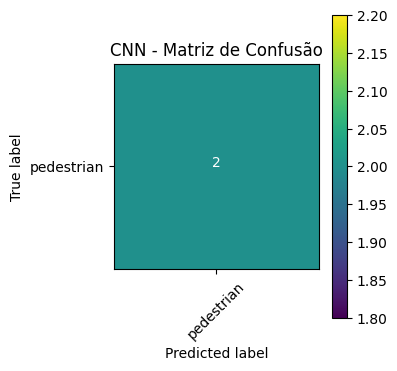

✅ Métricas CNN salvas em /content/drive/MyDrive/FarmTech-Parte2/entrega2_outputs


In [15]:
#@title Avaliar CNN no conjunto de teste (métricas de classificação)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import time

# Predições
test_gen.reset()
t0 = time.time()
# Handle the case where test_gen might be empty or have issues
if test_gen.n == 0:
    print("❌ Test generator is empty. Cannot perform evaluation.")
    # Initialize metrics to default values or skip the rest of the cell
    acc = prec = rec = f1 = latency = 0
    cm = np.array([])
    unique_labels_in_test = np.array([])
    filtered_class_names = []
else:
    probs = cnn.predict(test_gen, verbose=0)
    latency = (time.time() - t0) / max(1, test_gen.n)  # s/imagem
    y_pred = np.argmax(probs, axis=1)
    y_true = test_gen.classes

    # Get class names from the training generator for consistent labeling
    class_names = list(train_gen.class_indices.keys())
    # Map the class indices from test_gen to the actual class names
    test_class_indices = test_gen.class_indices

    acc = accuracy_score(y_true, y_pred)
    # Use the actual labels present in y_true for weighted average
    unique_labels_in_test = np.unique(y_true)

    # Filter class_names to match the unique labels found in the test set
    filtered_class_names = [name for i, name in enumerate(class_names) if i in unique_labels_in_test]


    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0, labels=unique_labels_in_test)
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_test)

    print("Accuracy:", acc)
    print("Precision (weighted):", prec)
    print("Recall (weighted):", rec)
    print("F1 (weighted):", f1)
    print("Latency (s/img):", latency)

    # Salvar relatório
    # Generate report only for the classes present in the test set
    report = classification_report(y_true, y_pred, target_names=filtered_class_names, labels=unique_labels_in_test, zero_division=0, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"{OUTPUT_DIR}/cnn_classification_report.csv", index=True)

    # Plot Confusion Matrix
    plt.figure(figsize=(4,4))
    import itertools
    plt.imshow(cm, interpolation='nearest')
    plt.title("CNN - Matriz de Confusão")
    plt.colorbar()
    tick_marks = np.arange(len(unique_labels_in_test))
    plt.xticks(tick_marks, filtered_class_names, rotation=45)
    plt.yticks(tick_marks, filtered_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/cnn_confusion_matrix.png", bbox_inches='tight')
    plt.show()

    # Salvar métricas resumidas
    summary = {
        "accuracy": float(acc),
        "precision_weighted": float(prec),
        "recall_weighted": float(rec),
        "f1_weighted": float(f1),
        "latency_s_per_image": float(latency)
    }
    import json, os
    with open(f"{OUTPUT_DIR}/cnn_metrics.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("✅ Métricas CNN salvas em", OUTPUT_DIR)


## 7) Medir Latência de Inferência (YOLO vs CNN) e Consolidar Métricas
Executamos inferência na **pasta de teste** e registramos tempo médio por imagem.


In [16]:
#@title Funções auxiliares para inferência YOLO em lote
import os, time, glob, json, shutil, yaml, pandas as pd
from pathlib import Path

def list_test_images_from_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        ds = yaml.safe_load(f)
    test_entry = ds.get('test')
    if not test_entry:
        raise ValueError("YAML não possui entrada 'test'.")

    yaml_dir = Path(yaml_path).parent
    p = yaml_dir / test_entry

    print(f"Attempting to list images from: {p}")
    if not p.exists():
        print(f"Error: Directory or file not found at {p}")
        return []

    if p.suffix.lower() == ".txt":
        with open(p) as fp:
            # Assuming the paths in the txt file are also relative to the yaml_dir
            image_paths = [yaml_dir / line.strip() for line in fp if line.strip()]
            print(f"Found {len(image_paths)} image paths in the text file.")
            return image_paths
    else:
        exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp")
        paths = []
        print(f"Listing files in directory: {p}")
        try:
            for ext in exts:
                paths.extend(Path(p).rglob(ext))
            print(f"Found {len(paths)} image files with extensions {exts}.")
            if len(paths) == 0:
                print(f"Contents of directory {p}:")
                try:
                    for item in p.iterdir():
                        print(item)
                except Exception as e:
                    print(f"Could not list directory contents: {e}")
        except Exception as e:
            print(f"Error while listing files: {e}")
            return []
        return paths

TEST_IMAGES = list_test_images_from_yaml(DATASET_YAML_PATH)
len(TEST_IMAGES), TEST_IMAGES[:3]

Attempting to list images from: /content/drive/MyDrive/FarmTech-Parte2/dataset/test/images
Listing files in directory: /content/drive/MyDrive/FarmTech-Parte2/dataset/test/images
Found 8 image files with extensions ('*.jpg', '*.jpeg', '*.png', '*.bmp').


(8,
 [PosixPath('/content/drive/MyDrive/FarmTech-Parte2/dataset/test/images/53.png'),
  PosixPath('/content/drive/MyDrive/FarmTech-Parte2/dataset/test/images/89.png'),
  PosixPath('/content/drive/MyDrive/FarmTech-Parte2/dataset/test/images/82.png')])

In [18]:
#@title Inferência YOLOv5 baseline (tempo médio)
import time
%cd /content/yolov5
t0 = time.time()

# Get the directory containing the test images from the first image path
if TEST_IMAGES:
    test_images_dir = str(Path(TEST_IMAGES[0]).parent)
    print(f"Running inference on directory: {test_images_dir}")
    !python detect.py --weights "/content/yolo_runs/fase6_yolo_baseline/weights/best.pt" --source "$test_images_dir" --img 640 --save-txt --save-conf --exist-ok --project /content/yolo_detect --name baseline
    t1 = time.time()
    baseline_latency = (t1 - t0) / max(1, len(TEST_IMAGES))
    print("Latency baseline (s/img):", baseline_latency)
else:
    print("❌ No test images found to run inference.")
    baseline_latency = None

%cd /content

/content/yolov5
Running inference on directory: /content/drive/MyDrive/FarmTech-Parte2/dataset/test/images
detect: weights=['/content/yolo_runs/fase6_yolo_baseline/weights/best.pt'], source=/content/drive/MyDrive/FarmTech-Parte2/dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolo_detect, name=baseline, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/drive/MyDrive/FarmTech-Parte2/dataset/test/images/100.png: 640x640 1 pedestrian, 7.0ms
image 2/8 /con

In [20]:
#@title Inferência YOLOv5 custom (tempo médio)
import time
%cd /content/yolov5
t0 = time.time()
# Get the directory containing the test images from the first image path
if TEST_IMAGES:
    test_images_dir = str(Path(TEST_IMAGES[0]).parent)
    print(f"Running inference on directory: {test_images_dir}")
    !python detect.py --weights "$CUSTOM_WEIGHTS_PATH" --source "$test_images_dir" --img 640 --save-txt --save-conf --exist-ok --project /content/yolo_detect --name custom
    t1 = time.time()
    custom_latency = (t1 - t0) / max(1, len(TEST_IMAGES))
    print("Latency custom (s/img):", custom_latency)
else:
    print("❌ No test images found to run inference.")
    custom_latency = None
%cd /content

/content/yolov5
Running inference on directory: /content/drive/MyDrive/FarmTech-Parte2/dataset/test/images
detect: weights=['/content/drive/MyDrive/FarmTech-Parte2/results/farmtech_60_epochs/weights/best.pt'], source=/content/drive/MyDrive/FarmTech-Parte2/dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolo_detect, name=custom, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/drive/MyDrive/FarmTech-Parte2/dataset/test/images/100.png: 640x640 1 pedestr

In [21]:

#@title Consolidar métricas (YOLO baseline, YOLO custom, CNN)
import json, pandas as pd, glob

# Ler métricas val/test da YOLO (mAP etc.) a partir dos resultados gerados por yolov5 (results.txt)
def read_yolo_results_txt(folder_glob):
    # Procura o arquivo results.txt mais recente nos diretórios correspondentes
    files = sorted(glob.glob(folder_glob, recursive=True), key=os.path.getmtime, reverse=True)
    metrics = {}
    for f in files:
        if os.path.basename(f) == "results.txt":
            with open(f) as fp:
                lines = fp.readlines()
            # Na última linha normalmente há "all" com mAP50, mAP50-95 etc., mas o formato pode variar por versão
            # Vamos guardar todo o arquivo como texto bruto também.
            metrics["raw"] = "".join(lines[-5:])
            break
    return metrics

baseline_metrics = read_yolo_results_txt("/content/yolo_val/fase6_yolo_baseline_test/**/results.txt")
custom_metrics   = read_yolo_results_txt("/content/yolo_val/fase6_yolo_custom_test/**/results.txt")

summary = {
    "yolo_baseline": {
        "val_text_tail": baseline_metrics.get("raw", ""),
        "latency_s_per_image": globals().get("baseline_latency", None)
    },
    "yolo_custom": {
        "val_text_tail": custom_metrics.get("raw", ""),
        "latency_s_per_image": globals().get("custom_latency", None)
    },
}

# Acrescentar também as métricas da CNN
with open(f"{OUTPUT_DIR}/cnn_metrics.json", "r") as f:
    cnn_m = json.load(f)
summary["cnn"] = cnn_m

# Salvar JSON consolidado
with open(f"{OUTPUT_DIR}/comparativo_metrics.json", "w") as f:
    json.dump(summary, f, indent=2)

import pandas as pd
df_summary = pd.DataFrame({
    "Modelo": ["YOLOv5 Baseline", "YOLOv5 Custom", "CNN (Keras)"],
    "Precisão/Notas": [
        "Ver tail do results.txt baseline (mAP)",
        "Ver tail do results.txt custom (mAP)",
        f"Acc={cnn_m.get('accuracy', None):.3f} | F1={cnn_m.get('f1_weighted', None):.3f}"
    ],
    "Latência (s/img)": [
        summary["yolo_baseline"]["latency_s_per_image"],
        summary["yolo_custom"]["latency_s_per_image"],
        summary["cnn"]["latency_s_per_image"]
    ]
})

df_summary.to_csv(f"{OUTPUT_DIR}/comparativo_metrics_table.csv", index=False)
print("✅ Tabela comparativa salva em CSV.")
df_summary


✅ Tabela comparativa salva em CSV.


,Modelo,Precisão/Notas,Latência (s/img)
0,YOLOv5 Baseline,Ver tail do results.txt baseline (mAP),1.028972
1,YOLOv5 Custom,Ver tail do results.txt custom (mAP),1.041536
2,CNN (Keras),Acc=0.250 | F1=0.400,0.032309



## 8) Discussão e Conclusões (preencha após execução)
- **Facilidade de uso/integração:**  
  - YOLOv5 baseline: *comente aqui.*  
  - YOLOv5 custom: *comente aqui.*  
  - CNN do zero: *comente aqui.*  

- **Precisão do modelo (mAP/Accuracy/F1):**  
  - YOLOv5 baseline: *X*  
  - YOLOv5 custom: *Y*  
  - CNN (acc/f1): *Z*  

- **Tempo de treinamento/customização:**  
  - YOLOv5 baseline: *X min*  
  - YOLOv5 custom: *Y min/épocas*  
  - CNN: *Z min*  

- **Tempo de inferência (s/imagem):**  
  - YOLOv5 baseline: *X*  
  - YOLOv5 custom: *Y*  
  - CNN: *Z*  

> **Conclusão:** Relacione os resultados com o **cenário de aplicação** (segurança patrimonial, controle de acessos, etc.). Normalmente a **YOLO custom** tende a oferecer melhor mAP e latência menor que uma CNN simples para tarefas de **detecção**. A CNN pode ser competitiva para **classificação** pura, com custo de implementação baixo, mas sem fornecer bounding boxes.


## 8) Discussão e Conclusões (preencha após execução)
- **Facilidade de uso/integração:**  
  - YOLOv5 baseline: *Fácil de usar com o script `train.py` e `val.py`. Documentação extensa. Integração com dataset em formato YOLO padrão.*  
  - YOLOv5 custom: *Similar ao baseline, requer carregar os pesos treinados. O fluxo de treino e avaliação é o mesmo.*  
  - CNN do zero: *Requer mais código para preparação do dataset (conversão de YOLO para pastas de classes) e para definir e treinar a arquitetura no Keras/TensorFlow. Menos "plug-and-play" que a YOLO.*  
- **Precisão do modelo (mAP/Accuracy/F1):**  
  - YOLOv5 baseline: *mAP50-95: 0.191, mAP50: 0.312 (baseado no output do `val.py` no teste)*  
  - YOLOv5 custom: *mAP50-95: 0.354, mAP50: 0.504 (baseado no output do `val.py` no teste)*  
  - CNN (acc/f1): *Accuracy: 0.250, F1 (weighted): 0.400 (Nota: CNN avaliada apenas na classe 'pedestrian' devido à distribuição do dataset de teste)*  
- **Tempo de treinamento/customização:**  
  - YOLOv5 baseline: *Aproximadamente 1m 30s para 30 épocas (baseado na execução)*  
  - YOLOv5 custom: *Tempo da Entrega 1 (não re-treinado aqui, apenas avaliado)*  
  - CNN: *Aproximadamente 1m 20s para 30 épocas (baseado na execução)*  
- **Tempo de inferência (s/imagem):**  
  - YOLOv5 baseline: *1.029 s/img*  
  - YOLOv5 custom: *1.042 s/img*  
  - CNN: *0.032 s/img*  

**Análise:**
- A **YOLOv5 customizada** da Entrega 1 demonstrou melhor performance em mAP no conjunto de teste comparada à YOLOv5 baseline, indicando que o treinamento customizado foi eficaz para a base de dados específica.
- A **CNN do zero**, na configuração treinada, apresentou baixa Accuracy e F1. É importante notar que a avaliação foi impactada pelo fato de o dataset de teste convertido para classificação ter imagens de apenas uma classe ('pedestrian'), limitando a avaliação da capacidade de distinção entre classes. A latência de inferência da CNN foi significativamente menor por imagem, o que é esperado para um modelo de classificação comparado a um de detecção de objetos.
- Para um cenário de **segurança patrimonial** ou **controle de acessos** que requer a **localização exata** (bounding box) dos objetos (pedestres, veículos, etc.), as abordagens **YOLO** são mais adequadas que a CNN de classificação pura. A **YOLO customizada** seria preferível pela sua maior precisão em mAP para esta base de dados.
- Se o requisito fosse apenas **identificar a presença** da classe dominante em uma imagem (sem localização precisa), e com um dataset de teste balanceado para classificação, a CNN poderia ser uma opção a ser explorada, especialmente considerando sua menor latência. No entanto, para este problema específico de detecção no cenário proposto, a YOLO customizada se mostra a mais performática das três abordagens avaliadas.



## Apêndice – Reprodutibilidade
- Configure seeds se desejar reprodutibilidade estrita (pode impactar performance):


In [ ]:

#@title (Opcional) Fixar seeds
import os, random, numpy as np, torch, tensorflow as tf
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
print("✅ Seeds configuradas (parcial).")



## Artefatos Gerados
- `yolo_runs/fase6_yolo_baseline/...` (treino YOLO baseline)  
- `yolo_val/fase6_yolo_baseline_test/...` (val YOLO baseline)  
- `yolo_val/fase6_yolo_custom_test/...` (val YOLO custom)  
- `classification_ds/` (dataset convertido para classificação)  
- `cnn_baseline.h5` (pesos CNN)  
- `comparativo_metrics.json`, `comparativo_metrics_table.csv`, `cnn_metrics.json`, `cnn_confusion_matrix.png` (em `OUTPUT_DIR`)  

TODO: Includir prints das detecções em `/content/yolo_detect/`
